# Preprocessing

In [28]:
import numpy,pandas
if __name__=='__main__':
    from sklearn.decomposition import PCA
    import numpy as np

    #For the preprocessing we need the data from Dream9.xlsx
    Dream9_training=pandas.read_excel('Dream9.xlsx',"trainingData") 
    Dream9_scoring=pandas.read_excel('Dream9.xlsx',"scoringData")
    Dream9=pandas.concat([Dream9_training,Dream9_scoring])

    #Division of types of Variables
    All=list(Dream9_training.keys())
    Sc=list(Dream9_scoring.keys())

    #Dependent variables are present in the training set but not in the scoring set
    Dependent=[]
    for v in All:
        if v not in Sc:
            Dependent+=[v]

    #Categorical variables have discrete values and can't be measured by euclidean distances
    Categorical=['SEX', 'PRIOR.MAL', 'PRIOR.CHEMO', 'PRIOR.XRT', 'Infection', 'cyto.cat', 
                 'ITD', 'D835', 'Ras.Stat', 'resp.simple', 'Relapse', 'vital.status']

    #The last 231 variables are proteins
    Protein=All[-231:]

#Trial_data=Dream9_training[Protein[:4]+Categorical[:4]+['cyto.cat']+Dependent].head()
#Trial_data.T

## Categorical variables
As a first approach we converted all the categorical variables to quantitative variables. Qualitative variables were converted into binary variables. For example, binary conversion was taken with 1 being Yes, Positive, or Female and 0 being No, Negative, or Male. For values without information, we treated the variables as NaN. In the special case of the variable “cyto.cat”, which indicates the cytogenetic category of the patient, we created a variable for each posible category, and used a 1 for the category that the patient falls under and 0 for all the different categories. For example, if the category is diploid, the value on the column ‘cyto.cat=diploid’ is set to be 1, and the value on the rest of the columns corresponding to cyto.cat, as ‘cyto.cat=inv9’ or ‘cyto.cat=-5,-7’ is equal to 0. 

In [2]:
def alias(Table,aliases):
    Aliased=[]
    for key in Alias_Dict:
        if key in Table.keys():
            Series=Table[key]
            new_Series=pandas.Series()
            new_Series.name=Series.name
            for key2,data in zip(Series.keys(),Series):
                new_Series[key2]=0.0
                for val in aliases[key]:
                    try:
                        if numpy.isnan(data):
                            new_Series[key2]=numpy.nan
                    except:
                        pass             
                    if data==val:
                        new_Series[key2]=aliases[key][val]
                        break
            Aliased+=[new_Series]
    return pandas.concat(Aliased,axis=1)
    
    #Changes the values on a Series with aliases as a dict that transform the old values in the new values
    

def split(Series,All_Data):
    #For Series with multiple values, creates a table with a column for each unique value
    #The value is True for the correct column and False for all the other columns
    D=[]
    for value in All_Data[Series.name].unique():
        q=(Series==value)*1.0
        q.name='%s=%s'%(q.name,value)
        D+=[q]
    return pandas.concat(D,axis=1)

#Example
#Alias_Dict={'SEX':{'F':1},'PRIOR.MAL':{'YES':1},'PRIOR.CHEMO':{'YES':1},'PRIOR.XRT':{'YES':1},
#                'Infection':{'Yes':1},'ITD':{'POS':1,'ND':numpy.nan},'D835':{'POS':1,'ND':numpy.nan},
#                'Ras.Stat':{'POS':1,'NotDone':numpy.nan},'resp.simple':{'CR':1},'Relapse':{'Yes':1},
#                'vital.status':{'A':1}}
#pandas.concat([Trial_data[Categorical[:4]+['cyto.cat']],alias(Trial_data,Alias_Dict),split(Trial_data['cyto.cat'],Dream9)],axis=1).T

,train_id_001,train_id_002,train_id_003,train_id_004,train_id_005
SEX,F,F,F,M,M
PRIOR.MAL,YES,NO,YES,NO,YES
PRIOR.CHEMO,NO,NO,YES,NO,NO
PRIOR.XRT,YES,NO,YES,NO,NO
cyto.cat,diploid,diploid,-5,IM,Misc
resp.simple,1,1,0,1,1
Relapse,0,1,NaN,1,1
vital.status,1,0,0,0,1
PRIOR.MAL,1,0,1,0,1
PRIOR.CHEMO,0,0,1,0,0


## Transformations on protein values
We noted that for some proteins, the extent of concentration was correlated with a change in the dependent variables. The protein data is normalized in a way that the expected mean is 0; values above the mean was 
assigned to be positive, and values below the mean was set to be negative. 

We created new variables to estimate the deviation from the mean squaring protein data to have better correlations to the expected values. 

In [3]:
def squared(Table):
    #This function squares all the values on a table
    D=[]
    for i,var in enumerate(Table.keys()):
        D+=[Table[var]**2]
        D[i].name='%s_Squared'%var
    return pandas.concat(D,axis=1)

def absolute(Table):
    #This function squares all the values on a table
    D=[]
    for i,var in enumerate(Table.keys()):
        D+=[(Table[var]**2)**0.5]
        D[i].name='%s_Absolute'%var
    return pandas.concat(D,axis=1)

#Example
#pandas.concat([Trial_data[Protein[:4]],squared(Trial_data[Protein[:4]]),absolute(Trial_data[Protein[:4]])],axis=1).T

,train_id_001,train_id_002,train_id_003,train_id_004,train_id_005
ACTB,0.185845,0.242502,0.555896,1.220082,0.283929
AIFM1,-0.217838,0.770727,0.331600,0.233040,2.404975
AKT1,-0.097350,0.277497,-1.614516,1.548541,-1.526024
AKT1_2_3.pS473,-0.272355,-0.518927,-1.046018,-1.120615,0.115397
ACTB_Squared,0.034538,0.058807,0.309020,1.488601,0.080616
AIFM1_Squared,0.047453,0.594019,0.109958,0.054308,5.783904
AKT1_Squared,0.009477,0.077004,2.606662,2.397978,2.328749
AKT1_2_3.pS473_Squared,0.074177,0.269285,1.094153,1.255779,0.013316
ACTB_Absolute,0.185845,0.242502,0.555896,1.220082,0.283929
AIFM1_Absolute,0.217838,0.770727,0.331600,0.233040,2.404975


## Cutoff of Dependent Data

On the second iteration of the algorithm, we altered the dependent Data with a cutoff at 130 weeks. We realized that the patients that survive (“vital.status”) have a long life expectancy (“Overall Survival”), which may not be correlated to any variable, but instead depend solely on the length of the study. To prevent the overfitting of the prediction caused by this anomaly, we used a cutoff on the dependent variables. We changed the “Overall Survival” to suppose that all the patients that live longer than 2.5 years (130 weeks) live just 130 weeks. We applied the same logic for Remission.

On the third iteration we binned the dependent data according to the extended challenge. 1 for less than 52 weeks, 2 for less than 104 weeks but more than 52 weeks and 3 for more than 104 weeks.

In [4]:
def cutoff(Table,cutoff):
    #This function makes values above a threeshold equal to the threeshold
    Tab=[]
    for key0 in Table.keys():
        Series=Table[key0]
        new_Series=Table[key0].copy()
        for key,data in zip(Series.keys(),Series):
            if data>cutoff:
                new_Series[key]=cutoff
            else:
                new_Series[key]=data
        new_Series.name='%s_cut'%Series.name
        Tab+=[new_Series]
    return pandas.concat(Tab,axis=1)

def binned(Table,bins=[0,52,104]):
    #This function will bin the results from Remission and Overall Survival as expected    
    Tab=[]
    for key0 in Table.keys():
        Series=Table[key0]
        bins = numpy.array(bins)
        digitized = list(numpy.digitize(Series, bins))
        for i,v in enumerate(Series):
            if numpy.isnan(v):
                digitized[i]=numpy.nan
        Tab+=[pandas.Series(digitized,index=Series.index,name='%s_binned'%Series.name)*52-26]
    return pandas.concat(Tab,axis=1)
#Example
#pandas.concat([Trial_data[Dependent[-2:]],cutoff(Trial_data[Dependent[-2:]],130),binned(Trial_data[Dependent[-2:]])],axis=1).T

,train_id_001,train_id_002,train_id_003,train_id_004,train_id_005
Overall_Survival,568.57,185.86,56.29,98.14,454.71
Remission_Duration,564.14,123.86,NaN,63.43,97.57
Overall_Survival_cut,130.00,130.00,56.29,98.14,130.00
Remission_Duration_cut,130.00,123.86,NaN,63.43,97.57
Overall_Survival_binned,130.00,130.00,78.00,78.00,130.00
Remission_Duration_binned,130.00,130.00,NaN,78.00,78.00


## PCA analysis
Since we were obtaining promising results on the analysis of variables by PCA, we created two sets of variables to include the PCA analysis of all the proteins and also the PCA analysis of the square of the protein data. These sets have been included since the second iteration of the algorithm.

In [5]:
def make_pca(Table,All_Data,n,name='PCA_test',whiten=False):
    pca = PCA(n_components=n,whiten=whiten)
    pca.fit(All_Data[Table.keys()])
    trans_PCA=pca.transform(Table)
    #Saving the components of the PCA
    components=pca.components_
    PCA_table=pandas.DataFrame(components,columns=Table.keys(),index=['%s_%i'%(name,i+1) for i in range(n)])
    PCA_table.to_csv('%s_components.csv'%name)
    #pca.explained_variance_ratio_##pca.get_params()
    #Needs to return the PCA transformation
    return pandas.DataFrame(trans_PCA,columns=['%s_%i'%(name,i+1) for i in range(n)],index=Table.index)
#pandas.concat([Trial_data[Protein[:4]],make_pca(Trial_data[Protein[:4]],Dream9,3),make_pca(Trial_data[Protein[:4]],Dream9,2,'Whiten_PCA',True)],axis=1).T

,train_id_001,train_id_002,train_id_003,train_id_004,train_id_005
ACTB,0.185845,0.242502,0.555896,1.220082,0.283929
AIFM1,-0.217838,0.770727,0.331600,0.233040,2.404975
AKT1,-0.097350,0.277497,-1.614516,1.548541,-1.526024
AKT1_2_3.pS473,-0.272355,-0.518927,-1.046018,-1.120615,0.115397
PCA_test_1,0.080583,-0.552849,-1.267444,0.392009,-2.246404
PCA_test_2,-0.355683,0.273182,-1.246942,-0.011675,0.838665
PCA_test_3,0.133678,0.662763,0.422849,1.861165,0.530524
Whiten_PCA_1,0.077147,-0.529274,-1.213398,0.375293,-2.150613
Whiten_PCA_2,-0.386816,0.297093,-1.356085,-0.012697,0.912072


## Binning of variables
We are bining the variables in subgroups of similar length. For this we sort the values of the variables (removing the NaN values) and then we select maximum values for each threeshold. If a variable is less or equal to the threeshold it will be included in the threeshold

In [6]:
def bin_independent(Table,All_Data,n,name='Binned'):
    Tab=[]
    Thre=[]
    for category in Table:
        #Read the values from all the data
        A=All_Data[category].values.copy()
        #Calculate the threesholds
        A=A[~numpy.isnan(A)]
        A.sort()
        Ts=[]
        for i in range(n):
            Ts+=[A[int(len(A)/float(n)*(i+1))-1]]
        #Make the new Series
        Ser=pandas.Series(Table[category].values.copy()*0,index=Table.index)
        for t in Ts:
            Ser=Ser+(Table[category]<=t)
        Ser.name='%s%i_%s'%(name,n,category)
        Tab+=[Ser]
        Thre+=[pandas.Series(Ts,index=['Threeshold %i'%(i+1) for i in range(len(Ts))],name=category)]
    Threesholds=pandas.concat(Thre,axis=1)
    Threesholds.to_csv('%s%i_Threesholds.csv'%(name,n))
    
    return pandas.concat(Tab,axis=1)

#bin_independent(Trial_data[Protein[:4]],Dream9,2)
#pandas.concat([Trial_data[Protein[:4]],bin_independent(Trial_data[Protein[:4]],Dream9,2),bin_independent(Trial_data[Protein[:4]],Dream9,3)],axis=1).T

,train_id_001,train_id_002,train_id_003,train_id_004,train_id_005
ACTB,0.185845,0.242502,0.555896,1.220082,0.283929
AIFM1,-0.217838,0.770727,0.331600,0.233040,2.404975
AKT1,-0.097350,0.277497,-1.614516,1.548541,-1.526024
AKT1_2_3.pS473,-0.272355,-0.518927,-1.046018,-1.120615,0.115397
Binned2_ACTB,1.000000,1.000000,1.000000,1.000000,1.000000
Binned2_AIFM1,2.000000,1.000000,1.000000,1.000000,1.000000
Binned2_AKT1,2.000000,1.000000,2.000000,1.000000,2.000000
Binned2_AKT1_2_3.pS473,2.000000,2.000000,2.000000,2.000000,1.000000
Binned3_ACTB,2.000000,2.000000,1.000000,1.000000,2.000000
Binned3_AIFM1,2.000000,1.000000,2.000000,2.000000,1.000000


## Not implemented

### Binning maximizing information gain
This is a bit complex to implement, but the idea was to try to bin the variables calculating the threeshold by information gain. The binning will depend on the dependent variable.

### Other ways
http://scikit-learn.org/stable/modules/preprocessing.html
http://scikit-learn.org/stable/modules/decomposition.html
http://scikit-learn.org/stable/modules/clustering.html

# Preprocessing main algorithm
Here we select the functions that we will be using to Preprocess the data.

In [21]:
def PreProcess(table,Dream9):
    #Select all variables that are not Categorical
    Tables=[table[[v for v in table.keys() if v not in Categorical]]]
    
    #Convert yes/no to 1/0
    Alias_Dict={'SEX':{'F':1},'PRIOR.MAL':{'YES':1},'PRIOR.CHEMO':{'YES':1},'PRIOR.XRT':{'YES':1},
                'Infection':{'Yes':1},'ITD':{'POS':1,'ND':numpy.nan},'D835':{'POS':1,'ND':numpy.nan},
                'Ras.Stat':{'POS':1,'NotDone':numpy.nan},'resp.simple':{'CR':1},'Relapse':{'Yes':1},
                'vital.status':{'A':1}}
    
    Tables+=[alias(table,Alias_Dict)]
    
    #Split data that has multiple values
    Tables+=[split(table['cyto.cat'],Dream9)]
    
    #Create new data for protein
    Tables+=[squared(table[Protein])]
    Tables+=[absolute(table[Protein])]
    Tables+=[bin_independent(table[Protein],Dream9,2)]
    Tables+=[bin_independent(table[Protein],Dream9,3)]
    Tables+=[bin_independent(table[Protein],Dream9,4)]
    Tables+=[bin_independent(table[Protein],Dream9,5)]
    
    #Make PCA axis
    Tables+=[make_pca(table[Protein],Dream9,200,name='PCA')]
    Tables+=[make_pca(table[Protein],Dream9,200,name='Whiten_PCA',whiten=True)]
    Tables+=[make_pca(squared(table[Protein]),squared(Dream9[Protein]),200,name='PCA_Sq')]
    
    #Bin dependent variables
    try:
        Tables+=[cutoff(table[['Overall_Survival','Remission_Duration']],130)]
        Tables+=[binned(table[['Overall_Survival','Remission_Duration']])]
    except KeyError:
        pass        
    
    #Join everything
    return pandas.concat(Tables,axis=1)

In [22]:
if __name__=='__main__':
   
    #This part is to test the function

    #Open the data and read in pandas
    Dream9_training=pandas.read_excel('Dream9.xlsx',"trainingData")
    Dream9_scoring=pandas.read_excel('Dream9.xlsx',"scoringData")
    Dream9=pandas.concat([Dream9_training,Dream9_scoring])

    #Create the new tables
    Q_training=PreProcess(Dream9_training,Dream9)
    Q_scoring=PreProcess(Dream9_scoring,Dream9)

    #Save the tables as csv
    Q_training.to_csv('Qtraining.csv')
    Q_scoring.to_csv('Qscoring.csv')

    #Number of columns and rows of new Table
    print Q_training.shape
    print Q_scoring.shape
    #A=binned(Dream9_training['Remission_Duration'])

(187, 2273)
(70, 2264)


In [23]:
#Q_training=PreProcess(Dream9_training,Dream9)
#Q_scoring=PreProcess(Dream9_scoring,Dream9)
Q_training=pandas.read_csv('Qtraining.csv')
Q_scoring=pandas.read_csv('Qscoring.csv')
Q_Dependent=[v for v in Q_training.keys() if v not in Q_scoring.keys()]

## Correlation of the variables

In [29]:
if __name__=='__main__':
    #Correlation for Continuous variables
    Corr=pandas.DataFrame()
    for Variable in Q_Dependent:
        C=Q_training[[t for t in Q_training.keys() if (t not in Q_Dependent)]+[Variable]].corr()[Variable][:-1]
        Corr=Corr.append(C)
    #Write correlation as csv
    Corr.T.to_csv('Correlations.csv')

In [30]:
if __name__=='__main__':
    #Most important Variables in Correlation
    for Variable in Q_Dependent:
        A=Corr.T[Variable]**2
        A.sort(ascending=False)
        print Corr[A.head(10).index].T[Variable]

Age.at.Dx             -0.347048
Binned2_PA2G4          0.263113
HGB                    0.258162
Binned2_HSP90AA1_B1    0.256085
Binned4_H3K27Me3      -0.240670
Binned3_H3K27Me3      -0.234479
Binned3_CASP7.cl198   -0.231518
Binned4_HSP90AA1_B1    0.231485
Binned5_HSP90AA1_B1    0.228896
Binned5_TRIM62        -0.228115
Name: Overall_Survival, dtype: float64
Binned2_PA2G4    0.303128
Whiten_PCA_21   -0.289692
PCA_21          -0.289692
Binned3_ARC      0.275134
Binned4_ARC      0.274341
Binned4_NRP1    -0.273465
ARC             -0.271760
Binned5_ARC      0.269516
Binned2_NRP1    -0.268501
Binned5_NRP1    -0.263683
Name: Remission_Duration, dtype: float64
Binned3_NPM1.3542    0.283984
Binned4_PIK3CA      -0.273393
Binned5_NPM1.3542    0.255464
NPM1.3542           -0.252036
Binned2_PIK3CA      -0.249048
PCA_Sq_146          -0.248592
Binned2_NPM1.3542    0.242168
CD34                -0.241693
PCA_Sq_38            0.239467
Binned5_ERG          0.238828
Name: resp.simple, dtype: float64
GAPDH_

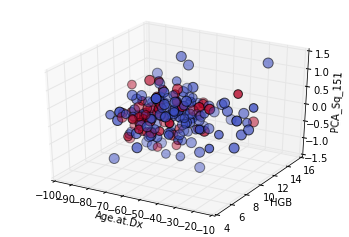

In [31]:
if __name__=='__main__':
    import numpy as np
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    import matplotlib
    %matplotlib inline

    x = -Q_training['Age.at.Dx']
    y = Q_training['HGB']
    z = -Q_training['PCA_Sq_151']
    area = Q_training['cyto.cat=diploid']*25+75 # 0 to 15 point radiuses
    colors = Q_training['resp.simple']

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel(x.name)
    ax.set_ylabel(y.name)
    ax.set_zlabel(z.name)
    ax.scatter(x, y, z,s=area, c=colors,cmap=matplotlib.cm.coolwarm_r)
    #Blue is 1 and red is 0
    plt.show()

## Information gain of the variables

In [32]:
#Calculate how much information in gained on each column
#Calculate the entropy of the subset
def information_gain(Table,Dependent,Independent):
    Table=Table[Table[Dependent].notnull()]
    freq=[]
    for dval in Table[Dependent].unique():
        freq+=[sum(Table[Dependent]==dval)]
    Freq=[float(f)/sum(freq) for f in freq]
    E=0
    for f in Freq:
        E+=-f*np.log(f)/np.log(2)
    #print 'Subset Entropy:', E
    Vars=[]

    #Calculate the entropy of each variable
    for ind in Independent:     
        if ind in Categorical:
            IG=E
            for ival in Table[ind].unique():
                if np.isnan(ival):
                    continue
                SubTable=Table[Table[ind]==ival]
                #print SubTable
                freq=[]
                for dval in Table[Dependent].unique():
                    freq+=[sum(SubTable[Dependent]==dval)]
                Freq=[float(f)/sum(freq) for f in freq]
                #print Freq
                ES=0
                for f in Freq:
                    ES+=-f*np.log(f)/np.log(2) if f<>0 else 0
                #print ES
                IG-=float(len(SubTable))/len(Table)*ES
            #print 'Information gain from %s: %f'%(ind,IG)
            Vars+=[(IG,ind)]
        else:
            Threeshold=[]
            prev_SubTableA_len=0
            for ival in np.arange(min(Table[ind]),max(Table[ind]),(max(Table[ind])-min(Table[ind]))/500.0):
                IG=E
                SubTableA=Table[Table[ind]<ival]
                SubTableB=Table[Table[ind]>=ival]
                if len(SubTableA)<1 or len(SubTableB)<1:
                    continue
                if len(SubTableA)==prev_SubTableA_len:
                    continue
                else:
                    prev_SubTableA_len=len(SubTableA)
                freq=[]
                for dval in Table[Dependent].unique():
                    freq+=[sum(SubTableA[Dependent]==dval)]
                Freq=[float(f)/sum(freq) for f in freq]
                #print Freq
                ES=0
                for f in Freq:
                    ES+=-f*np.log(f)/np.log(2) if f<>0 else 0
                #print ES
                IG-=float(len(SubTableA))/len(Table)*ES
                #print SubTable
                freq=[]
                for dval in Table[Dependent].unique():
                    freq+=[sum(SubTableB[Dependent]==dval)]
                Freq=[float(f)/sum(freq) for f in freq]
                #print Freq
                ES=0
                for f in Freq:
                    ES+=-f*np.log(f)/np.log(2) if f<>0 else 0
                #print ES
                IG-=float(len(SubTableB))/len(Table)*ES
                Threeshold+=[(IG,ival)]
            Threeshold.sort(reverse=True)
            #print Threeshold
            #break
            #print 'Information gain from %s: %f at theeshold:%f'%(ind,Threeshold[0][0],Threeshold[0][1])
            if len(Threeshold)>0:
                Vars+=[(Threeshold[0][0],ind,Threeshold[0][1])]
            else:
                Vars+=[(0,ind)]
    Information_gain=pandas.Series([v[0] for v in Vars],index=[v[1] for v in Vars],name='Information Gain')
    Threesholds=pandas.Series([v[2] for v in Vars if len(v)>2],index=[v[1] for v in Vars if len(v)>2],name='Threeshold')
    return pandas.concat([Information_gain,Threesholds],axis=1)

if __name__=='__main__':
    Q_Cat=['resp.simple','Relapse','vital.status','Overall_Survival_binned','Remission_Duration_binned']
    Ts=[]
    for Variable in Q_Cat:
        print Variable
        Independent=[v for v in Q_training.keys() if v in Q_scoring.keys()]
        Ts+=[information_gain(Q_training,Variable,Independent)]
    Information_Gain=pandas.concat(Ts,keys=Q_Cat,axis=1)
    Information_Gain.to_csv('InformationGain.csv')

resp.simple
Relapse
vital.status
Overall_Survival_binned
Remission_Duration_binned


In [33]:
#Most important variables in Information Gain
if __name__=='__main__':
    for Variable in Q_Cat:
        A=Information_Gain[Variable]
        A=A.sort('Information Gain',ascending=False)
        A.name=Variable
        print Variable
        print A.head()

resp.simple
            Information Gain  Threeshold
Ras.Stat            0.153163         NaN
NPM1.3542           0.080603   -0.316711
PCA_Sq_38           0.074556    0.543310
FIBRINOGEN          0.073998  701.000000
CD34                0.072572   15.048000

[5 rows x 2 columns]
Relapse
           Information Gain   Threeshold
Ras.Stat           0.202722          NaN
CD13               0.099785    17.170400
LDH                0.098036  3968.890000
ITD                0.094247          NaN
PCA_Sq_37          0.091788     0.034578

[5 rows x 2 columns]
vital.status
            Information Gain  Threeshold
Ras.Stat            0.148631         NaN
Age.at.Dx           0.106737   67.510720
PCA_Sq_180          0.077880   -0.187574
CD20                0.069857   17.040000
CD13                0.067860   96.040000

[5 rows x 2 columns]
Overall_Survival_binned
            Information Gain  Threeshold
Ras.Stat            0.272291         NaN
FIBRINOGEN          0.138471    524.3480
CD20            

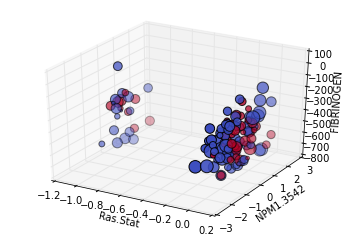

In [34]:
if __name__=='__main__':
    import numpy as np
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    import matplotlib
    %matplotlib inline

    x = -Q_training['Ras.Stat']
    y = Q_training['NPM1.3542']
    z = -Q_training['FIBRINOGEN']
    area = Q_training['PCA_Sq_38']*25+75 # 0 to 15 point radiuses
    colors = Q_training['resp.simple']

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel(x.name)
    ax.set_ylabel(y.name)
    ax.set_zlabel(z.name)
    ax.scatter(x, y, z,s=area, c=colors,cmap=matplotlib.cm.coolwarm_r)
    #Blue is 1 and red is 0
    plt.show()

## Create Selection tables